In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA

wd = %pwd
if wd.split('\\')[-1] == 'notebooks':
    %cd ..

from coursemate.dataset import Dataset
nltk.download('wordnet', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

c:\Users\Timia\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


c:\Development\School-UNSW\COMP9727\project\comp9727-project


True

In [3]:
dataset = Dataset('data/Coursera_courses.csv', 'data/Coursera.csv', 'data/Coursera_reviews.csv')
dataset.set_interaction_counts(3, 50)
dataset.set_train_test_split_by_ratings(ratio=0.8)
training_matrix, test_matrix = dataset.get_train_test_matrices()

Loading Coursera courses...
Loading Coursera reviews...
Segmenting out students with less than 3 or more than 50 reviews...
Setting the train-test split by rating...


174219it [00:11, 15207.30it/s]


Computing the training and test rating matrix...


128771it [00:09, 13937.23it/s]
45448it [00:03, 14666.79it/s]


In [4]:
train_df = dataset.train_ratings.merge(dataset.df_courses, how='left',on='course_id')
test_df = dataset.test_ratings.merge(dataset.df_courses, how='left',on='course_id')
users = dataset.student_set.copy(deep=True)
courses = dataset.course_set.copy(deep=True)

In [ ]:
test_df

In [100]:
grouped_df = train_df.groupby('reviewers')['course_id'].count()
filtered_df = grouped_df[grouped_df > 3]
filtered_df.head()

# reviewer_ids = filtered_df.index.tolist()
# reviewer_ids
#train_df[train_df['reviewers'] == 'a a a']['course_id']

reviewers
                  4
18it042 c j       4
2516_anirudh g    6
a                 4
a a a             4
Name: course_id, dtype: int64

In [5]:
print(len(train_df), len(test_df))
print(len(pd.unique(train_df['reviewers'])),len(pd.unique(test_df['reviewers'])))
print(len(users), len(courses))

128771 45448
30719 30719
30719 468


In [6]:
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def process_skills(skill_text):
    skills = set(skill_text.replace(')','').replace('(','').replace('-',' ').lower().split())
    return ' '.join(skills)

def process_description(description):
    description = description.lower()
    description = re.sub(r'[^\w\s]', '', description)
    tokens = word_tokenize(description)
    tokens = [word for word in tokens if word not in stop_words]
    
    #tokens = [ps.stem(word) for word in tokens]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

def process_reviewers(reviewer):
    reviewer = reviewer.lower()
    reviewer = re.sub(r'[^\w\s]', '', reviewer).replace('by ', '').strip()
    return reviewer

train_df['reviewers'] = train_df['reviewers'].apply(process_reviewers)
test_df['reviewers'] = test_df['reviewers'].apply(process_reviewers)

train_df['skills'] = train_df['skills'].apply(process_skills)
test_df['skills'] = test_df['skills'].apply(process_skills)

train_df['description'] = train_df['description'].apply(process_description)
test_df['description'] = test_df['description'].apply(process_description)

courses['description'] = courses['description'].apply(process_description)

In [110]:
def make_recommendations(user_id,vectorizer):
    user_reviewed_courses = train_df[train_df['reviewers'] == user_id]['course_id'].unique()

    user_vector = vectorizer.transform(train_df[train_df['course_id'].isin(user_reviewed_courses)]['description'])
    most_similar_courses = find_most_similar_courses(user_vector,vectorizer,user_reviewed_courses)
    
    
    print("Courses taken: ", user_reviewed_courses)
    print("\nCourses recommended:")
    recommended_courses = []
    for course_id, similarity in most_similar_courses:
        print(f'{course_id:<50}\t{similarity:.3f}')
        recommended_courses.append(course_id)

    #return recommended_courses


def find_most_similar_courses(user_vector,vectorizer,user_reviewed_courses):   
    most_similar_courses = []
    for other_course_id in courses.index:
        if other_course_id in user_reviewed_courses:
            continue

        desc = train_df[train_df['course_id'] == other_course_id]['description']
        if desc.shape[0] == 0:
            continue

        desc = desc.iloc[0]
        course_vector = vectorizer.transform([desc])
        similarity = cosine_similarity(user_vector, course_vector)
        most_similar_courses.append((other_course_id, similarity.mean()))
        
    most_similar_courses.sort(key=lambda x: x[1], reverse=True)
    
    return most_similar_courses[:10]


tfid = TfidfVectorizer()
tfid.fit(courses['description'])

make_recommendations('2516_anirudh g',tfid)

Courses taken:  ['web-development' 'computer-networking' 'os-power-user'
 'introduction-cybersecurity-cyber-attacks'
 'cybersecurity-roles-processes-operating-system-security'
 'cybersecurity-compliance-framework-system-administration']

Courses recommended:
technical-support-fundamentals               	0.225
introduction-to-cloud                        	0.185
system-administration-it-infrastructure-services	0.180
gcp-infrastructure-foundation                	0.176
gcp-infrastructure-core-services             	0.157
gcp-infrastructure-scaling-automation        	0.147
cloud-infrastructure-design-process          	0.144
foundations-big-data-analysis-sql            	0.139
google-cloud-java-spring                     	0.129
build-a-computer                             	0.119


In [76]:
x = train_df['description']
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(x, show_progress_bar=False)

In [77]:
X = np.array(embeddings)
n_comp = 5
pca = PCA(n_components=n_comp)
pca.fit(X)
pca_data = pd.DataFrame(pca.transform(X))
pca_data.head()
#sns.pairplot(pca_data)

,0,1,2,3,4
0,-4.739921,1.920827,1.363567,0.578686,-2.804769
1,-4.024076,2.980651,0.924009,-1.402440,-1.057387
2,4.329090,4.375109,-0.155131,0.203904,1.331723
3,-0.455767,1.211621,1.040504,-3.157043,0.709499
4,-5.739543,1.225743,0.448553,0.756524,-0.071907


In [78]:
cos_sim_data = pd.DataFrame(cosine_similarity(X))
data = df.copy(deep=True).reset_index()
def give_recommendations(index,print_recommendation = False,print_recommendation_plots= False,print_genres =False):
  index_recomm =cos_sim_data.loc[index].sort_values(ascending=False).index.tolist()[1:6]

  courses_recomm =  data['name'].iloc[index_recomm].values
  result = {'Courses':courses_recomm,'Index':index_recomm}
  if print_recommendation==True:
    print('The attended course is this one: %s \n'%(data['name'].iloc[index]))
    k=1
    for movie in courses_recomm:
      print('The number %i recommended course is this one: %s \n'%(k,movie))
  if print_recommendation_plots==True:
    print('The plot of the watched movie is this one:\n %s \n'%(data['description'].iloc[index]))
    k=1
    for q in range(len(courses_recomm)):
      plot_q = df['description'].iloc[index_recomm[q]]
      print('The plot of the number %i recommended course is this one:\n %s \n'%(k,plot_q))
      k=k+1
  if print_genres==True:
    print('The skills of the attended course is this one:\n %s \n'%(data['skills'].iloc[index]))
    k=1
    for q in range(len(courses_recomm)):
      plot_q = data['skills'].iloc[index_recomm[q]]
      print('The skills of the number %i recommended course is this one:\n %s \n'%(k,plot_q))
      k=k+1
  return result
give_recommendations(2,False,False,True)


MemoryError: Unable to allocate 61.8 GiB for an array with shape (128771, 128771) and data type float32

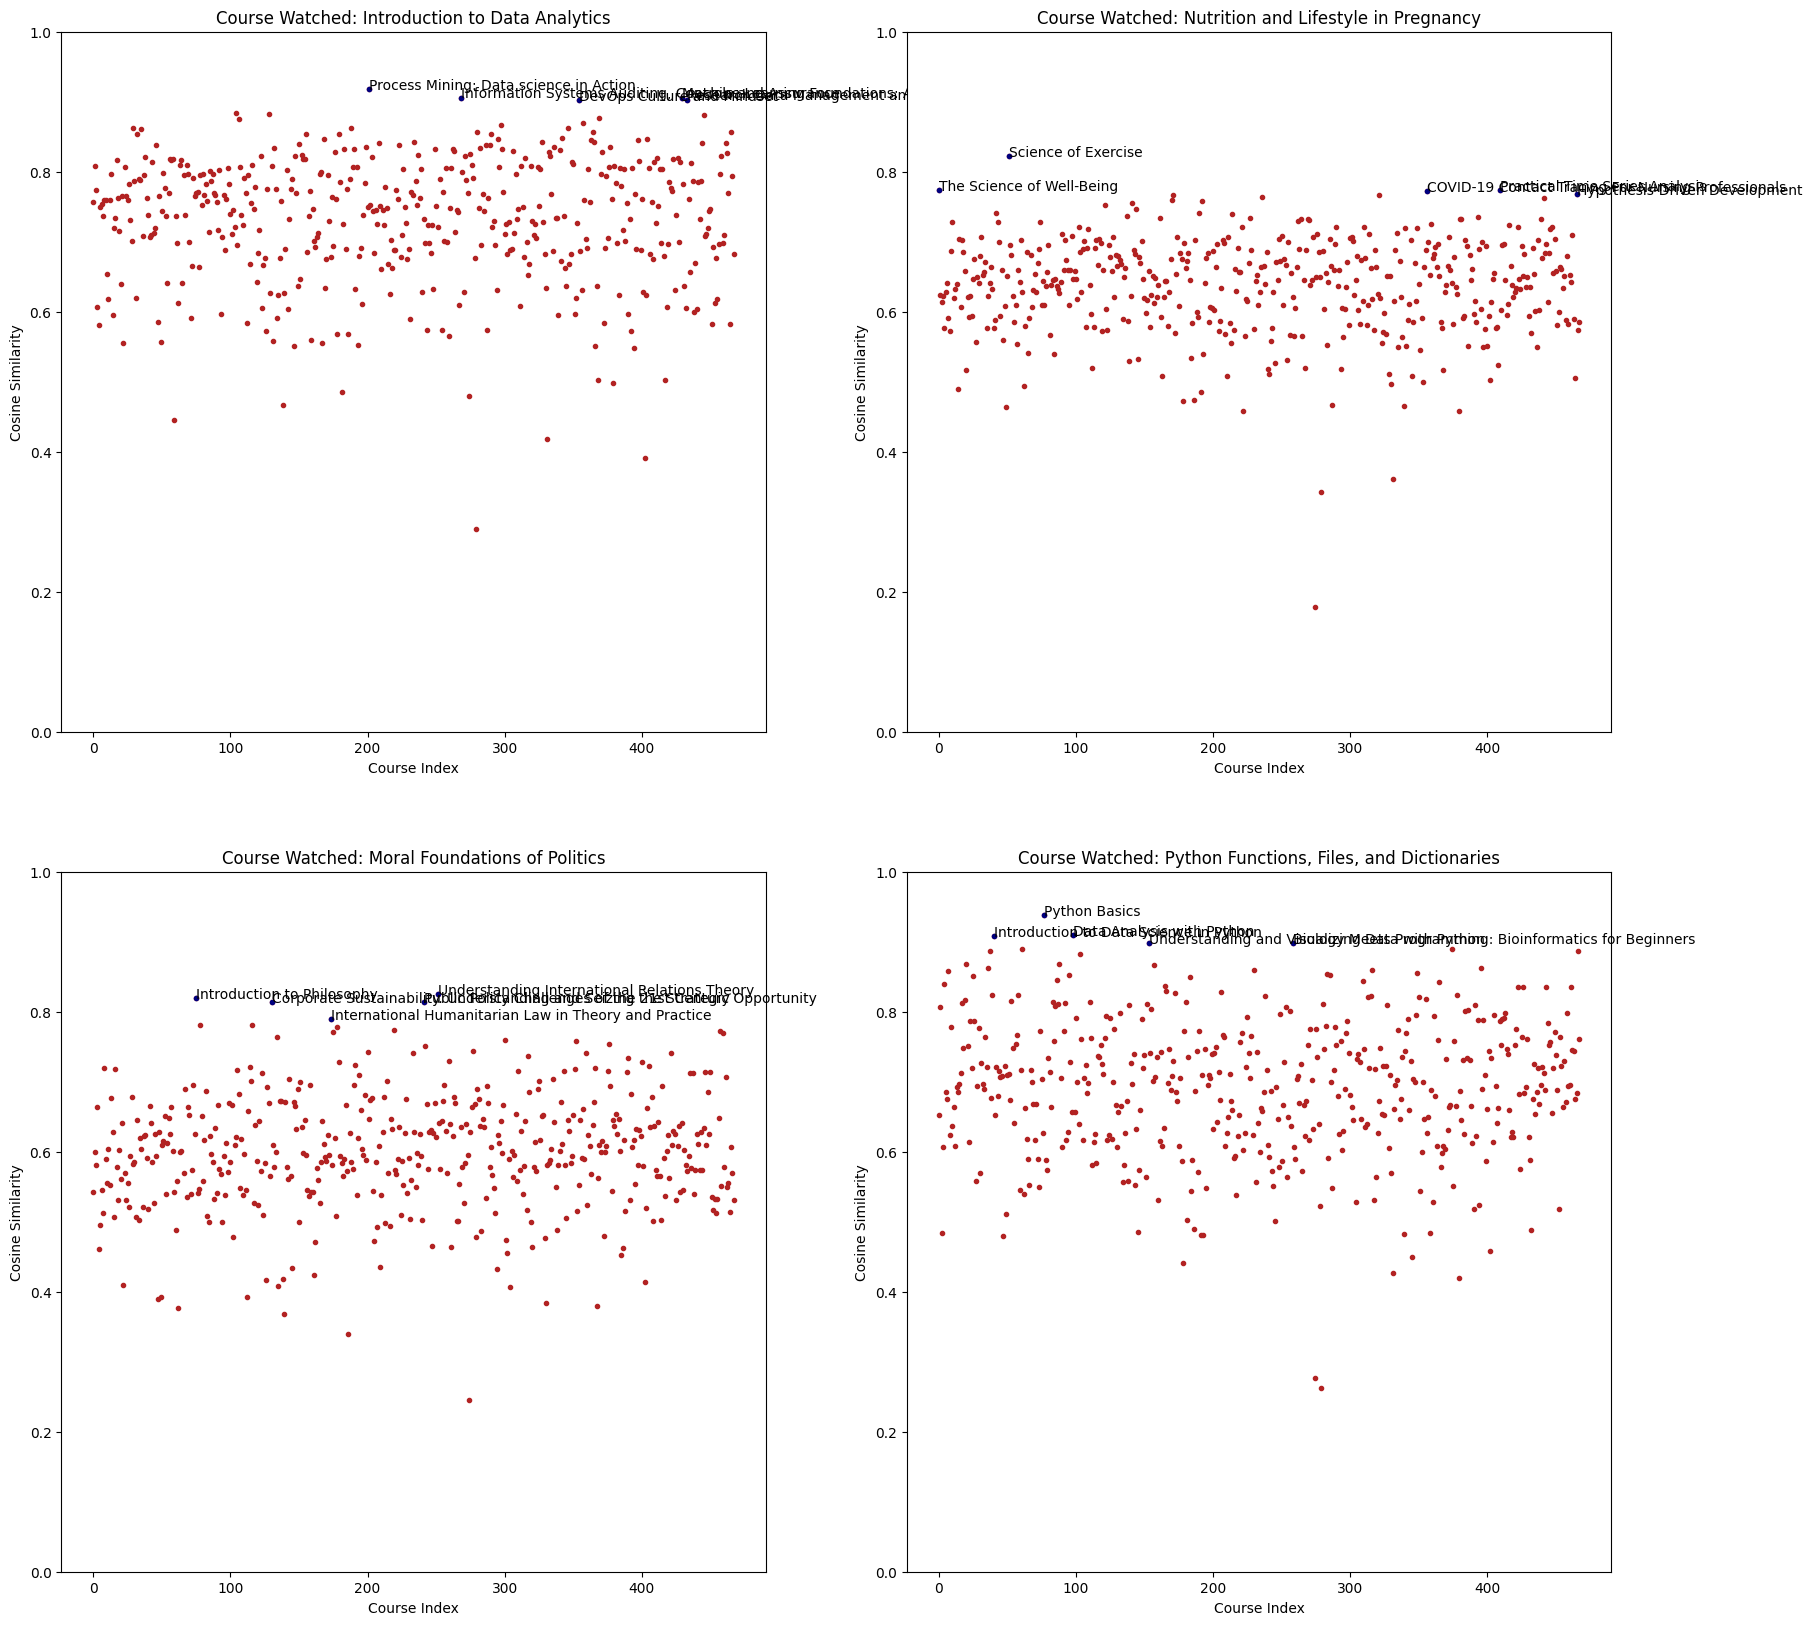

In [ ]:
plt.figure(figsize=(20,20))
for q in range(1,5):
  plt.subplot(2,2,q)
  index = np.random.choice(np.arange(0,len(X)))
  to_plot_data = cos_sim_data.drop(index,axis=1)
  plt.plot(to_plot_data.iloc[index],'.',color='firebrick')
  recomm_index = give_recommendations(index)
  x = recomm_index['Index']
  y = cos_sim_data.iloc[index][x].tolist()
  m = recomm_index['Courses']
  plt.plot(x,y,'.',color='navy',label='Recommended Courses')
  plt.title('Course Watched: '+data['name'].iloc[index])
  plt.xlabel('Course Index')
  k=0
  for x_i in x:
    plt.annotate('%s'%(m[k]),(x_i,y[k]),fontsize=10)
    k=k+1

  plt.ylabel('Cosine Similarity')
  plt.ylim(0,1)